# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,\
                    accuracy_score, f1_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/sms-spam-collection-dataset/spam.csv


# **Loading Data**

In [2]:
spam_message = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')
spam_message.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# information about dataset
spam_message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
# dropping unwanted columns 
spam_message.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [5]:
# rename the dependent feature as 'type' and independent feature as 'text'
spam_message.rename(columns = {'v1':'type', 'v2':'text'}, inplace = True)

In [6]:
spam_message.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


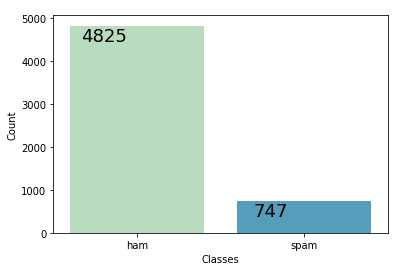

In [7]:
# visualizing target classes 
pal = sns.color_palette("GnBu",n_colors=2)
ax = sns.countplot(x='type',palette=pal, data=spam_message)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.2,p.get_height()),  ha='center', va='center', size=18)
ax.set(xlabel="Classes", ylabel="Count")
plt.show()

# **Data Preprocessing**

In [8]:
# changing target feature with numeric values 0 and 1
spam_message['type'] = spam_message['type'].apply(lambda x: 0 if x == 'ham' else 1)

In [9]:
#  data before cleaning
spam_message['text'].head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: text, dtype: object

In [10]:
# cleaning text
# converting characters into lowercase
# removing punctuation and numbers
spam_message['text'] = spam_message['text'].apply(lambda x : x.lower())
spam_message['text'] = spam_message['text'].apply(lambda x : re.sub('[^a-zA-Z]',' ', x))
spam_message['text'] =spam_message['text'].apply(lambda x : " ".join([word for word in x.split()]))

In [11]:
# removing stopwords (frequently occurring words such as few, is, an, etc)

spam_message['text'] =spam_message['text'].apply(lambda x : " ".join([word for word in x.split() \
                                                              if word not in stopwords.words('english')]))


In [12]:
# data after removing punctuation, numbers and stopwords
spam_message['text'].head(5)

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4               nah think goes usf lives around though
Name: text, dtype: object

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [14]:
# Tokenization (Spliting each sentences into words) and 
# lemmatization (Converts a word to its root form. In this case, language is English and 
# after lemmatization, the output would be into English word)

lemma = WordNetLemmatizer()
spam_message['text'] =spam_message['text'].apply(lambda x : " ".join([lemma.lemmatize(word,pos='v') for word in nltk.word_tokenize(x)]))


In [15]:
# final data to build the model
spam_message.head()

,type,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joke wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think go usf live around though


# **Defining Target and Independent Features**

In [16]:
Y = spam_message['type']
X = spam_message['text']

# **Spliting the Dataset for Training & Testing**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values,test_size = 0.2,random_state =3)

# **Converting Text data into Vector form**

In [18]:
# using TF-IDF word vectorization technique to convert our text data into numerical format.

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)


# **Model Building and Evaluation**

In [19]:
#  Model training and evaluation
acc_list =[]
recall_list =[]
precision_list =[]
f1_score_list = []

def modelEval(xtr,ytr,xte,yte,model):
    
    model.fit(xtr,ytr)
    
    # Prediction for Test and Train Dataset
    test_pred=model.predict(xte)
    train_pred =model.predict(xtr)
    
    tpr_score = metrics.precision_score(ytr, train_pred)
    trc_score = metrics.recall_score(ytr, train_pred)
    tac_score =metrics.accuracy_score(ytr,train_pred)

    # Making Confusion Matrix and calculating accuracy score
    print("For Training Dataset.")   
    print(f'Accuracy: {tac_score:.4f}, Precision: {tpr_score:.2f}, Recall: {trc_score:.2f}')
    print("===============================")
    pr_score = metrics.precision_score(yte, test_pred)
    rc_score = metrics.recall_score(yte, test_pred)
    ac_score = metrics.accuracy_score(yte, test_pred)
    f1_sore = metrics.f1_score(yte, test_pred)
    
    print("===============================")
    print("===============================")
    print("For Testing Dataset")
    print("===============================")
    print(f'Accuracy: {ac_score:.2f}, Precision: {pr_score:.2f}, Recall: {rc_score:.2f}')
    print("===============================")
    print(classification_report(yte,test_pred))
    metrics.plot_confusion_matrix(model,xte,yte,cmap='GnBu')
    
    acc_list.append(round(ac_score,2))
    recall_list.append(round(rc_score,2))
    precision_list.append(round(pr_score,2))
    f1_score_list.append(round(f1_sore,2))
    


#  **Support Vector Classifier**

For Training Dataset.
Accuracy: 0.9933, Precision: 0.99, Recall: 0.96
For Testing Dataset
Accuracy: 0.99, Precision: 0.99, Recall: 0.90
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       960
           1       0.99      0.90      0.95       155

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



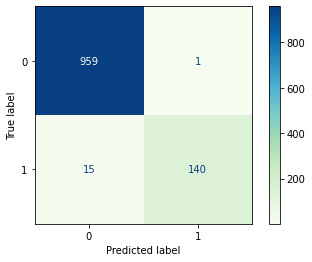

In [20]:
svc_model = svm.SVC(kernel= 'linear')
modelEval(train_vectors,y_train,test_vectors,y_test,svc_model)

# **Naive Bayes Model**

For Training Dataset.
Accuracy: 0.9778, Precision: 1.00, Recall: 0.83
For Testing Dataset
Accuracy: 0.97, Precision: 1.00, Recall: 0.75
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       960
           1       1.00      0.75      0.86       155

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



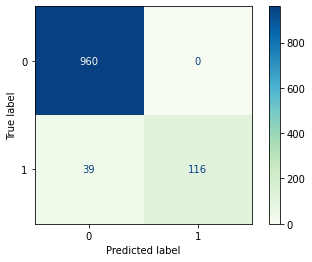

In [21]:
spam_detect_model = naive_bayes.MultinomialNB()
modelEval(train_vectors,y_train,test_vectors,y_test,spam_detect_model)

# **K-Nearest Neighbors**

For Training Dataset.
Accuracy: 0.9300, Precision: 1.00, Recall: 0.47
For Testing Dataset
Accuracy: 0.91, Precision: 1.00, Recall: 0.37
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       960
           1       1.00      0.37      0.54       155

    accuracy                           0.91      1115
   macro avg       0.95      0.68      0.74      1115
weighted avg       0.92      0.91      0.89      1115



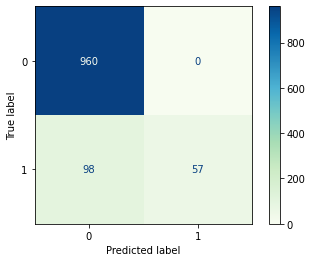

In [22]:
knn_model = KNeighborsClassifier()
modelEval(train_vectors,y_train,test_vectors,y_test,knn_model)

# **Random Forest Classifier**

For Training Dataset.
Accuracy: 1.0000, Precision: 1.00, Recall: 1.00
For Testing Dataset
Accuracy: 0.98, Precision: 1.00, Recall: 0.86
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       960
           1       1.00      0.86      0.92       155

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



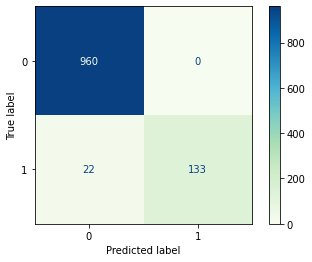

In [23]:
rf_model = RandomForestClassifier()
modelEval(train_vectors,y_train,test_vectors,y_test,rf_model)

In [24]:
# initialise data with model results
data = {'Accuracy':acc_list,
'Precision':precision_list,
'Recall':recall_list,
'F1score':f1_score_list}

# creates pandas DataFrame 
output = pd.DataFrame(data, index =["SVC","NaiveBayes","KNN" ,"RandomForest"])

In [25]:
print("Results for Testing Dataset")
output.style.background_gradient(cmap='GnBu')

Results for Testing Dataset


,Accuracy,Precision,Recall,F1score
SVC,0.990000,0.990000,0.900000,0.950000
NaiveBayes,0.970000,1.000000,0.750000,0.860000
KNN,0.910000,1.000000,0.370000,0.540000
RandomForest,0.980000,1.000000,0.860000,0.920000


**Thank you for reviewing my notebook.**

**Please, write your comments for me.**

**If you liked my notebook, please upvote.**